In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

# custom modules
#...
#...


In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


# Load data

In [3]:
PATH_df = "/home/simon/Documents/scripts/VIEWS_FAO_index/data/raw_viewser/simon_full_base_01_viewser_df.pkl"
df = pd.read_pickle(PATH_df)
# validate_dataframe(df)

# Starting with monthly

## Sanity plot

In [4]:
def plot_monthly_data(df, month_ids, columns, figsize=(18, 25), cmap="rainbow", alpha=0.6, marker='.', s=6):
    """
    Plots a 3x3 grid of scatter plots for specified month_ids and columns.

    Parameters:
    - df: pandas DataFrame containing the data
    - month_ids: list of month_ids to plot
    - columns: list of columns to plot
    - figsize: tuple specifying the figure size
    - cmap: colormap for the scatter plots
    - alpha: transparency level of the markers
    - marker: marker style for the scatter plots
    - s: size of the markers
    """
    # Create a 3x3 subplot
    fig, axes = plt.subplots(nrows=len(columns), ncols=3, figsize=figsize)

    # Iterate over the rows and columns to create each subplot
    for i, col in enumerate(columns):
        for j, month_id in enumerate(month_ids):
            ax = axes[i, j]
            filtered_df = df[df["month_id"] == month_id]
            scatter = ax.scatter(filtered_df["col"], filtered_df["row"], c=filtered_df[col], cmap=cmap, alpha=alpha, marker=marker, s=s)
            
            # Add a color bar if the value is a float
            if filtered_df[col].dtype == "float64":
                cbar = plt.colorbar(scatter, ax=ax)
                cbar.set_label(col)
            
            # Add labels and title
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            ax.set_title(f'{col} for Month ID {month_id}')
            
            # Add grid
            ax.grid(True, linestyle='--', alpha=0.5)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()



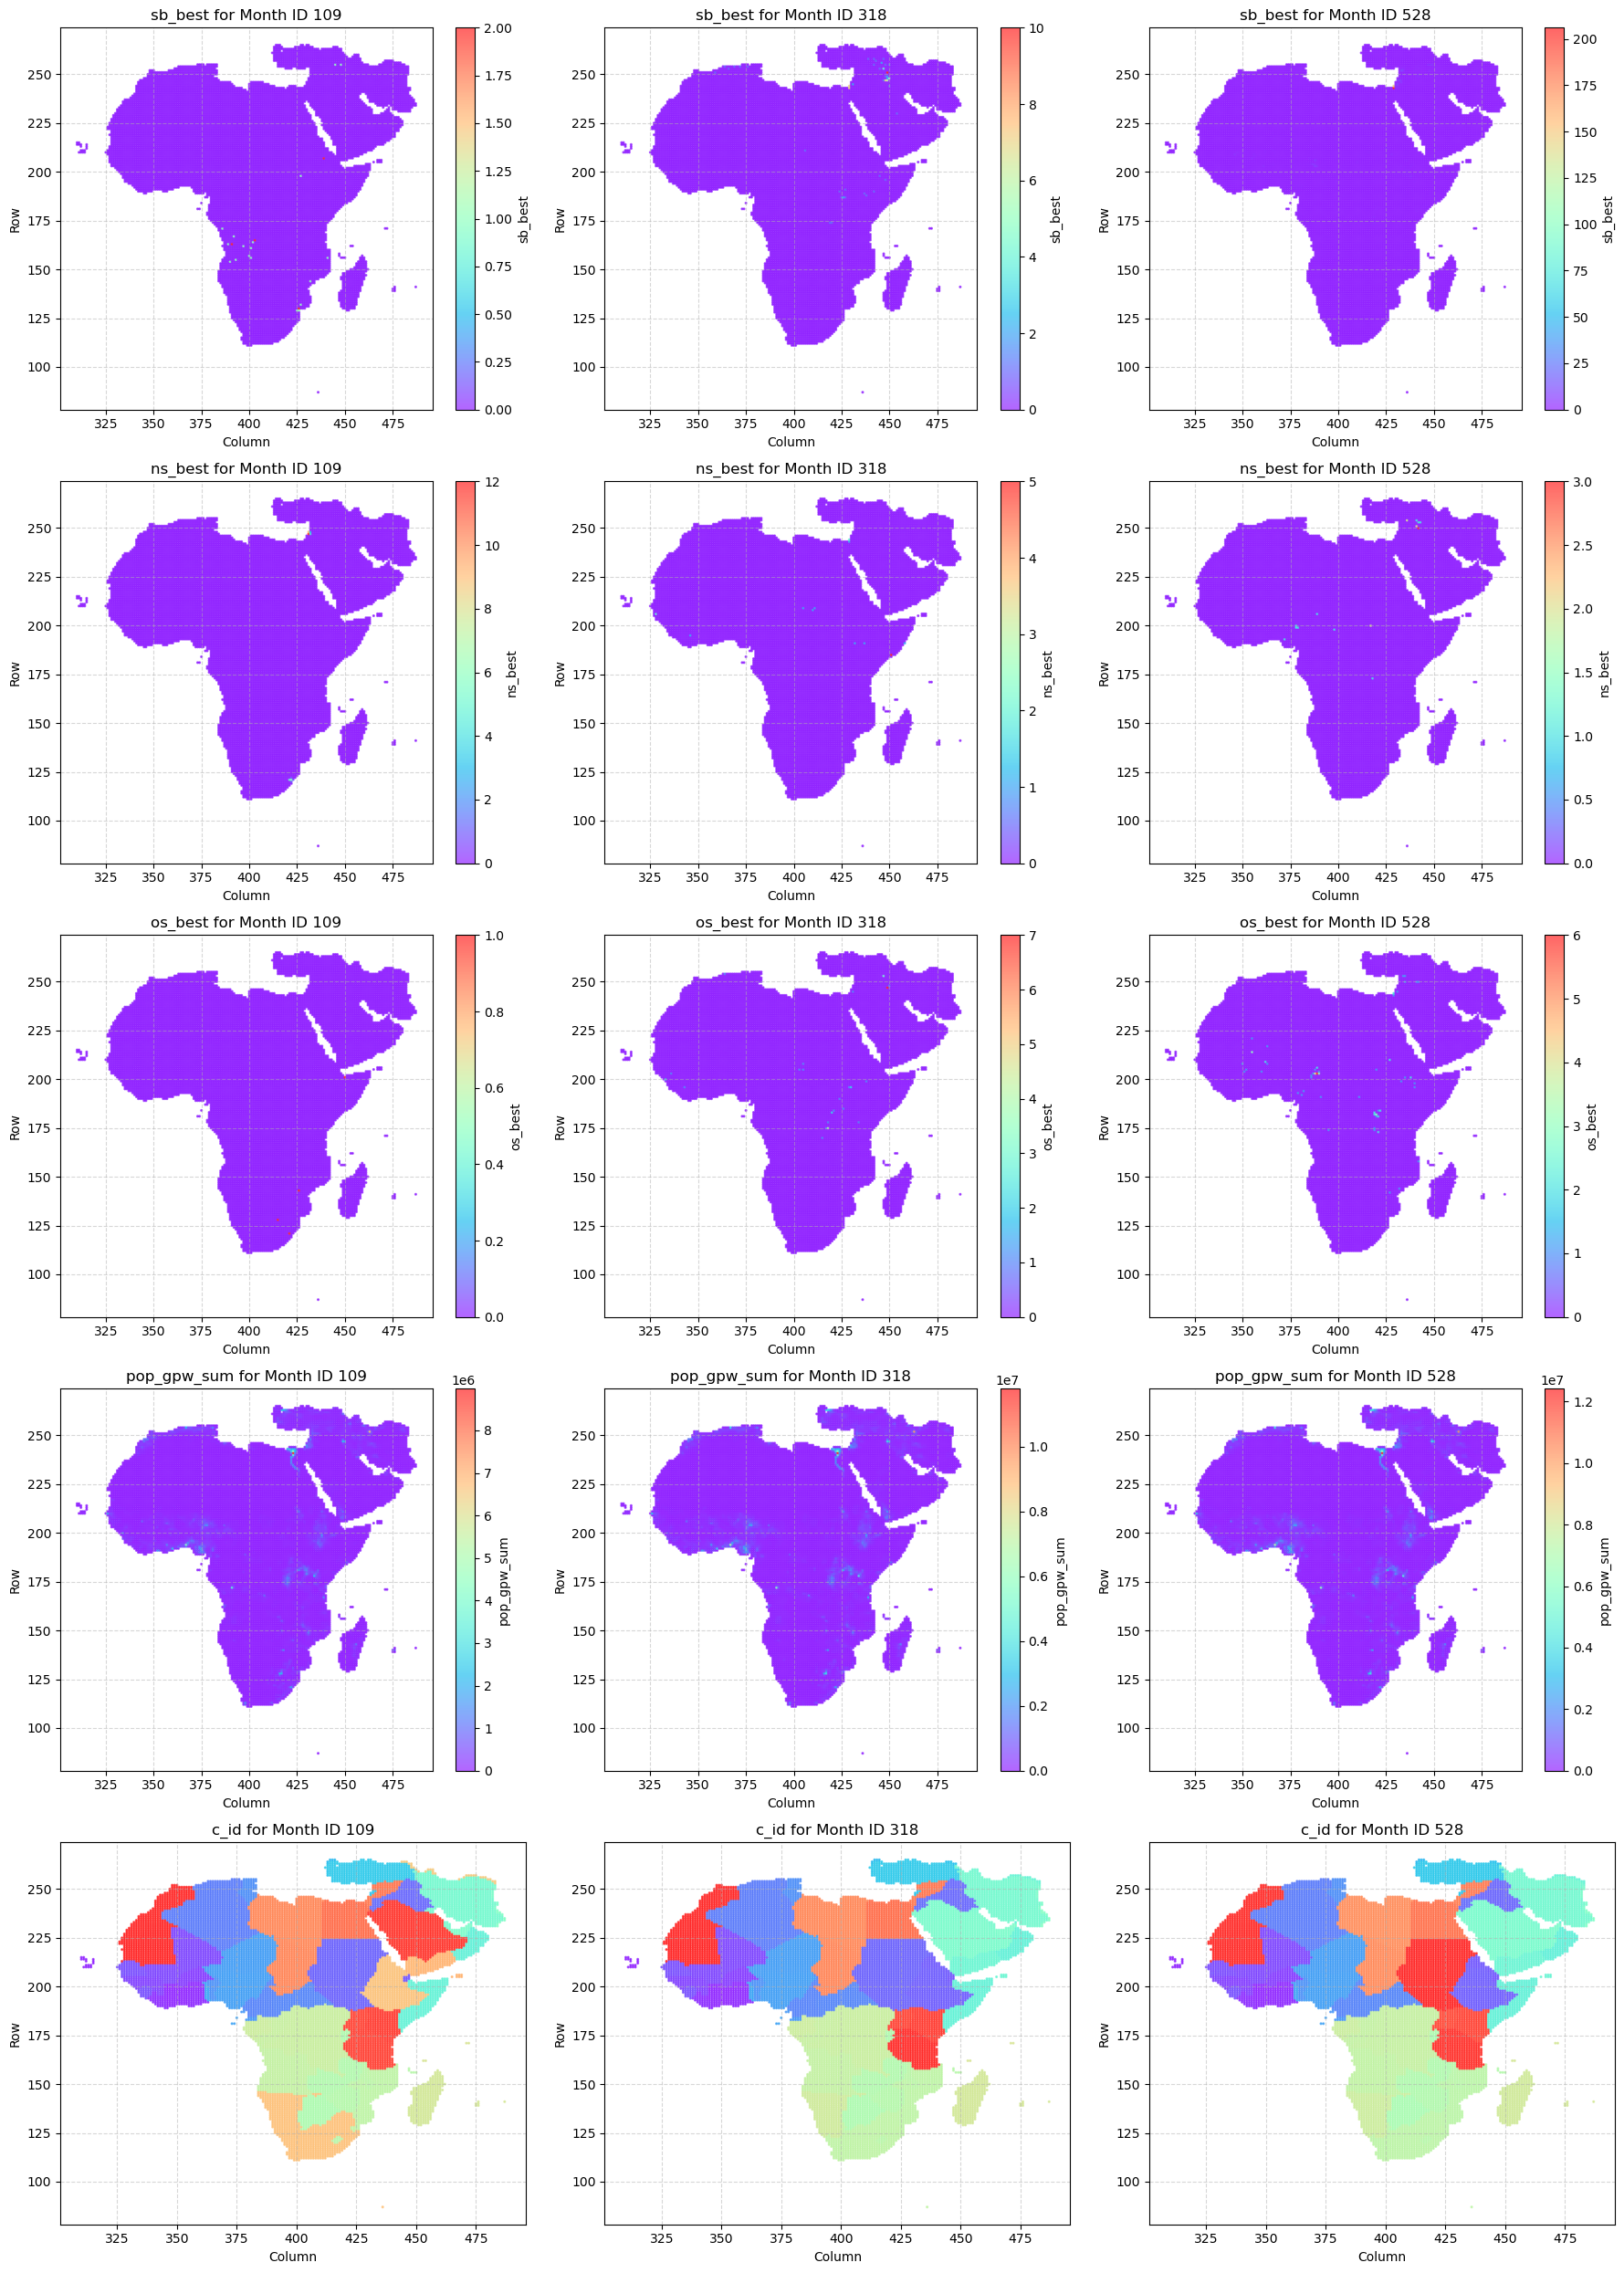

In [5]:
month_ids = [109, 318, 528]
columns = ['sb_best', 'ns_best', 'os_best', 'pop_gpw_sum', 'c_id']
plot_monthly_data(df, month_ids, columns)

## Feature engineering

In [6]:
def feature_eng_fat_per_100k(df):
    """
    Perform feature engineering to calculate fatalities per 100,000 population.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing conflict data.

    Returns:
    pd.DataFrame: Modified DataFrame with new features.
    """
    # Feature engineering

    # Totally best (fatalities)
    df['total_best'] = df['sb_best'] + df['ns_best'] + df['os_best']

    # Population normalization counts
    n_pop = 100000

    # Replace zero population values with NaN using the recommended method
    df.replace({'pop_gpw_sum': {0: np.nan}}, inplace=True)

    # Fatalities per 100,000 population for each type of conflict
    df['fatalities_per_100k'] = (df['total_best'] / df['pop_gpw_sum']) * n_pop
    df['sb_per_100k'] = (df['sb_best'] / df['pop_gpw_sum']) * n_pop
    df['ns_per_100k'] = (df['ns_best'] / df['pop_gpw_sum']) * n_pop
    df['os_per_100k'] = (df['os_best'] / df['pop_gpw_sum']) * n_pop

    # Fill NaNs with 0 - NaN values are created when dividing by 0 population, so it makes sense to fill them with 0
    df.fillna(0, inplace=True)

    # Test that all the new columns are created and have valid values:

    # Check for the existence of the new columns
    new_columns = ['fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']
    for col in new_columns:
        assert col in df.columns, f"Column {col} is missing from the DataFrame"

    # Check for the correct data types
    for col in new_columns:
        assert np.issubdtype(df[col].dtype, np.number), f"Column {col} does not have a numeric data type"

    # Check for the correct number of rows
    assert len(df) == len(df.dropna()), "The number of rows in the DataFrame has changed"

    # Above 0
    assert df['fatalities_per_100k'].min() >= 0
    assert df['sb_per_100k'].min() >= 0
    assert df['ns_per_100k'].min() >= 0
    assert df['os_per_100k'].min() >= 0

    # Not NaN, Inf or -Inf
    assert not df['fatalities_per_100k'].isnull().values.any()
    assert not df['sb_per_100k'].isnull().values.any()
    assert not df['ns_per_100k'].isnull().values.any()
    assert not df['os_per_100k'].isnull().values.any()

    assert not np.isinf(df['fatalities_per_100k']).values.any()
    assert not np.isinf(df['sb_per_100k']).values.any()
    assert not np.isinf(df['ns_per_100k']).values.any()
    assert not np.isinf(df['os_per_100k']).values.any()

    assert not np.isneginf(df['fatalities_per_100k']).values.any()
    assert not np.isneginf(df['sb_per_100k']).values.any()
    assert not np.isneginf(df['ns_per_100k']).values.any()
    assert not np.isneginf(df['os_per_100k']).values.any()

    return df

In [7]:
df_fe = feature_eng_fat_per_100k(df)

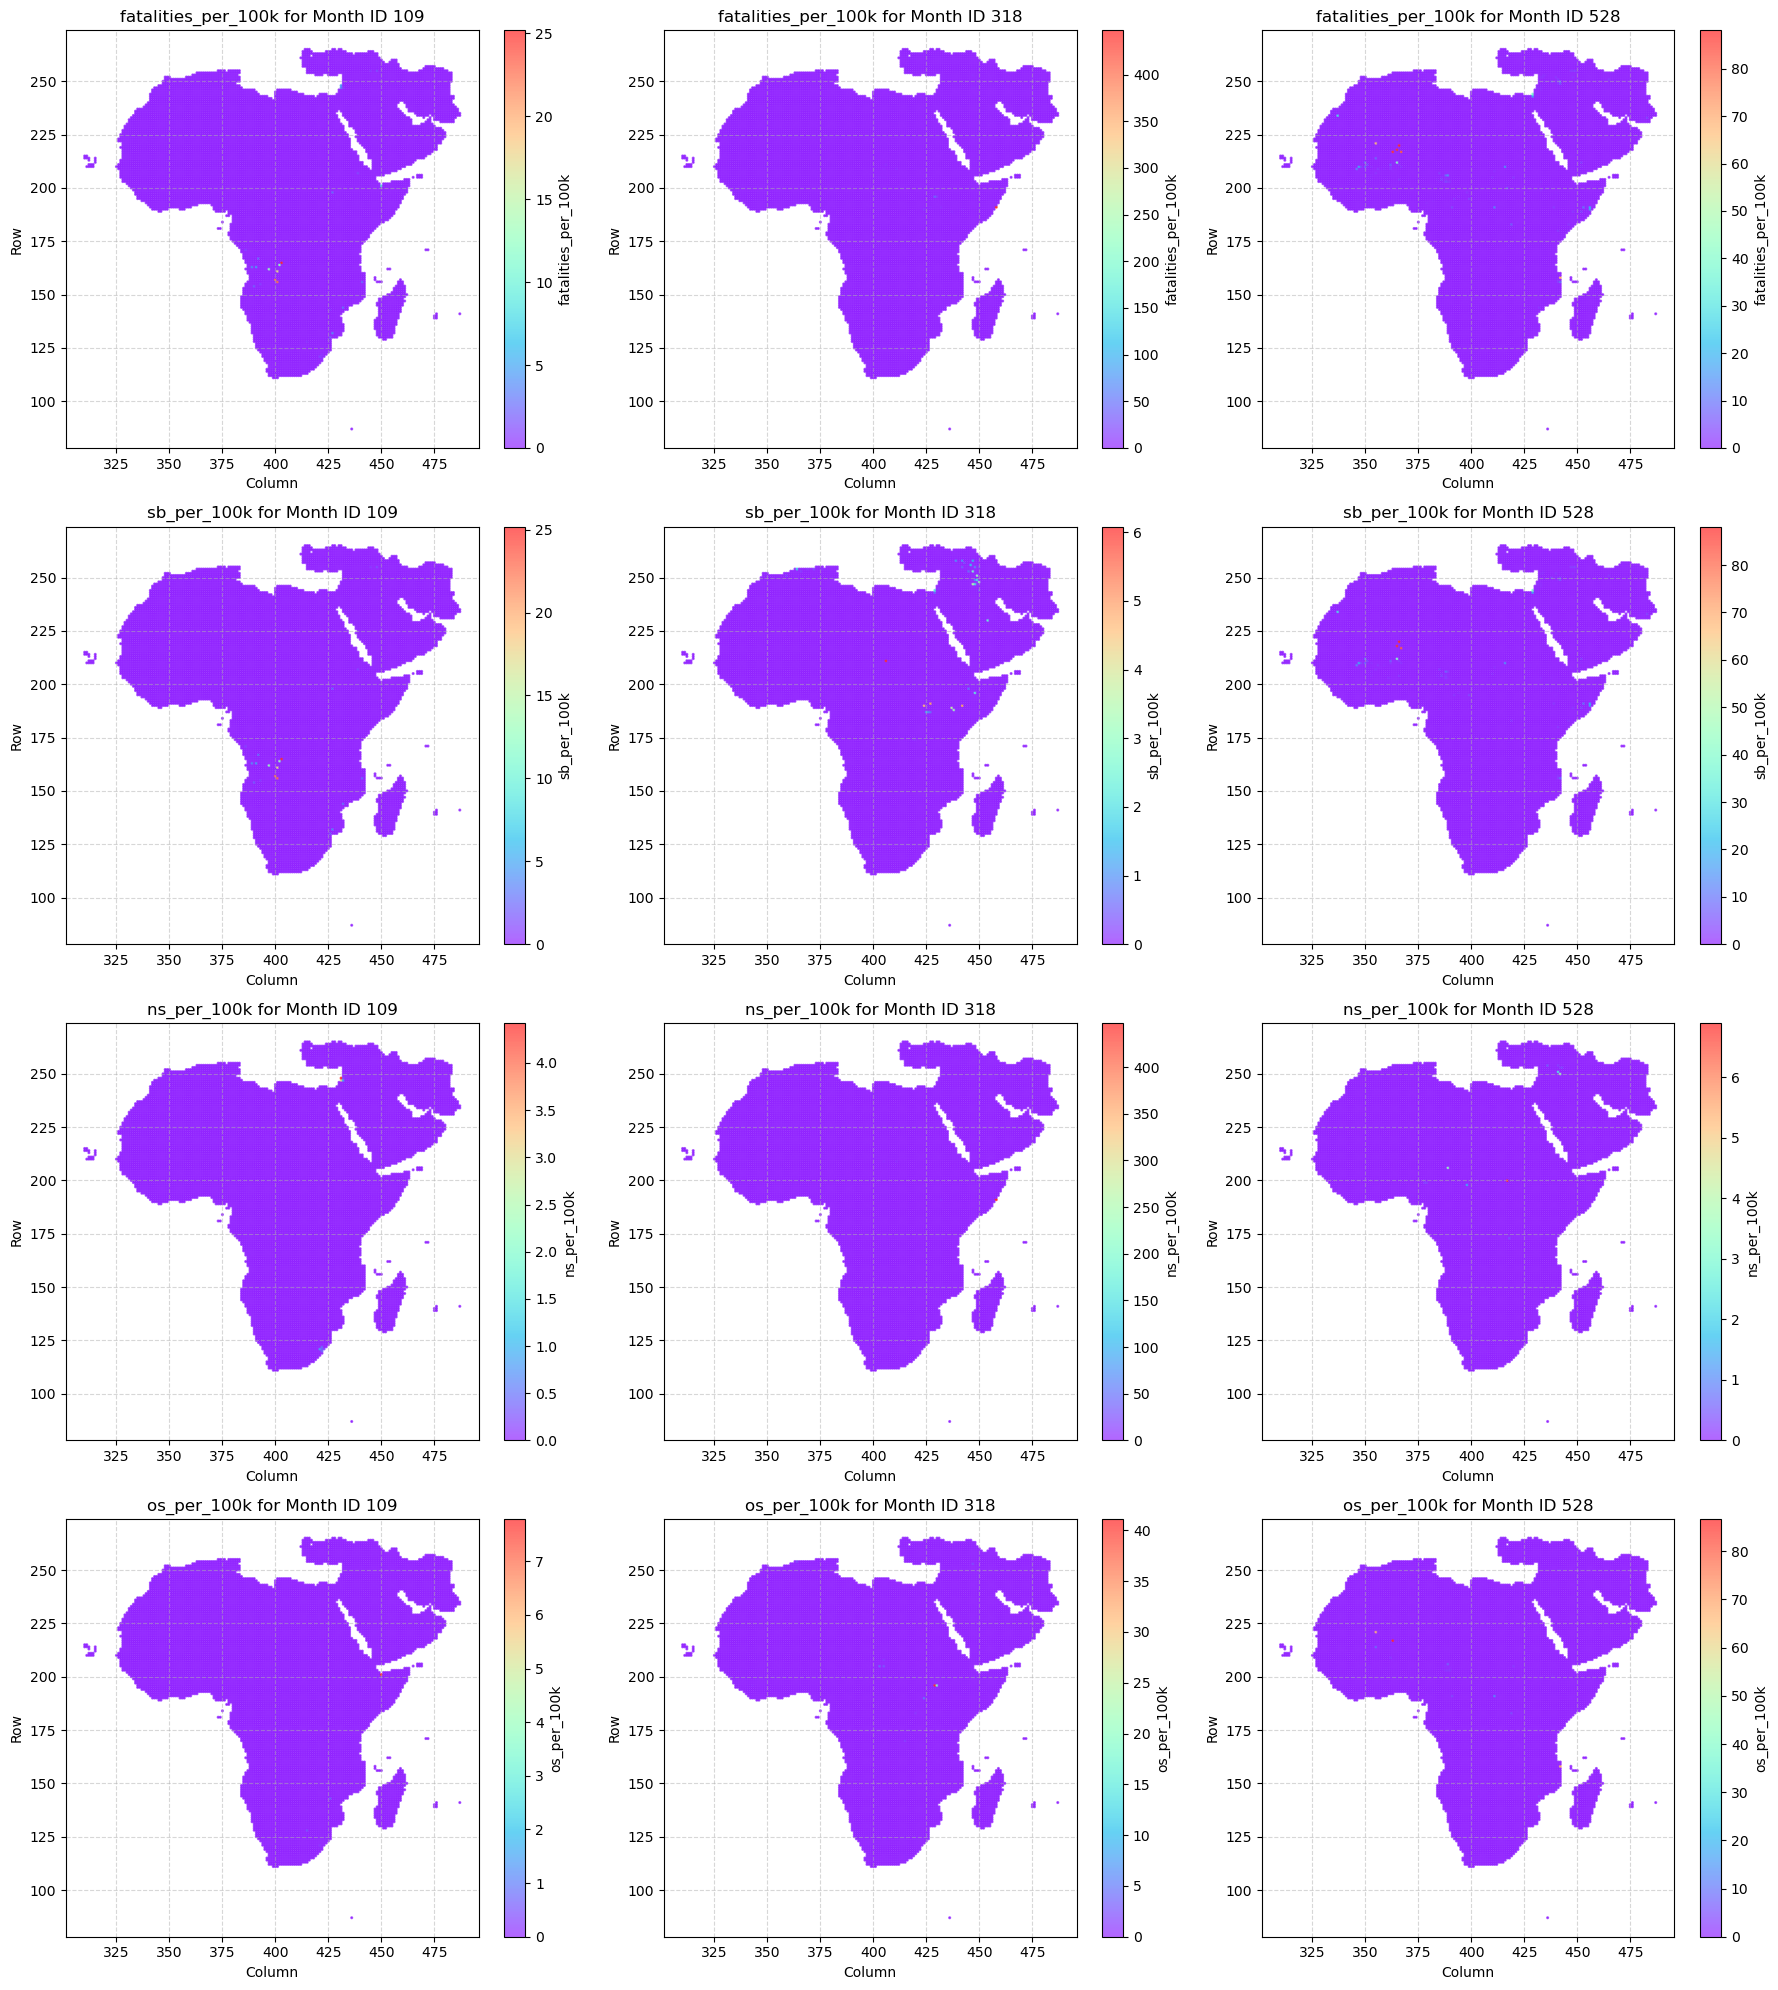

In [8]:
month_ids = [109, 318, 528]
columns = ['fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']
plot_monthly_data(df_fe, month_ids, columns, figsize=(18, 20))

In [9]:
df_fe

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
1415880       109   62356      1     1989   192  436   87      0.0      0.0   
1415881       109   79599      1     1989   192  399  111      0.0      0.0   
1415882       109   79600      1     1989   192  400  111      0.0      0.0   
1415883       109   79601      1     1989   192  401  111      0.0      0.0   
1415884       109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
6922075       528  190496     12     2023    89  416  265      0.0      0.0   
6922076       528  190507     12     2023    96  427  265      0.0      0.0   
6922077       528  190508     12     2023    96  428  265      0.0      0.0   
6922078       528  190510     12     2023    96  430  265      0.0      0.0   
6922079       528  190511     12     2023    96  431  265      0.0      0.0   

         os_best    pop_gpw_sum  total_best  fatalities_per_100k  sb_per_100k  \
1415880      0.0       0.000000         0.0                  0.0          0.0   
1415881      0.0    3890.091064         0.0                  0.0          0.0   
1415882      0.0    2452.416016         0.0                  0.0          0.0   
1415883      0.0   11328.425781         0.0                  0.0          0.0   
1415884      0.0  313145.781250         0.0                  0.0          0.0   
...          ...            ...         ...                  ...          ...   
6922075      0.0   33143.308594         0.0                  0.0          0.0   
6922076      0.0     769.687866         0.0                  0.0          0.0   
6922077      0.0      94.784584         0.0                  0.0          0.0   
6922078      0.0    2036.697510         0.0                  0.0          0.0   
6922079      0.0    1989.386230         0.0                  0.0          0.0   

         ns_per_100k  os_per_100k  
1415880          0.0          0.0  
1415881          0.0          0.0  
1415882          0.0          0.0  
1415883          0.0          0.0  
1415884          0.0          0.0  
...              ...          ...  
6922075          0.0          0.0  
6922076          0.0          0.0  
6922077          0.0          0.0  
6922078          0.0          0.0  
6922079          0.0          0.0  

[5506200 rows x 16 columns]

### Lest first go global

In [10]:
def calculate_cumulative_distribution(df, value_col):
    """
    Calculate the cumulative distribution of values across all voxels.

    Parameters:
    df (pd.DataFrame): The dataframe containing voxel data.
    value_col (str): The name of the column containing voxel values.

    Returns:
    pd.Series: A series representing the cumulative distribution.

    Raises:
    ValueError: If the DataFrame is empty.
    KeyError: If the specified column does not exist in the DataFrame.
    TypeError: If the specified column does not contain numeric values.
    """
    # Check if the DataFrame is empty
    if df.empty:
        raise ValueError("The input DataFrame is empty.")
    
    # Check if the column exists in the DataFrame
    if value_col not in df.columns:
        raise KeyError(f"The column '{value_col}' does not exist in the DataFrame.")
    
    # Check if the column contains numeric values
    if not np.issubdtype(df[value_col].dtype, np.number):
        raise TypeError(f"The column '{value_col}' does not contain numeric values.")
    
    # Calculate the frequency of each unique value
    value_counts = df[value_col].value_counts().sort_index(ascending=False)
    
    # Compute the cumulative distribution
    cumulative_distribution = value_counts.cumsum()
    
    # Check if the cumulative distribution is correctly calculated
    if cumulative_distribution.empty:
        raise ValueError("The cumulative distribution calculation resulted in an empty series.")
    
    return cumulative_distribution

In [11]:
def plot_cumulative_distribution(cumulative_distribution, x_label, y_label, title):
    """
    Plots the cumulative distribution with a log scale on the y-axis.

    Parameters:
    cumulative_distribution (pd.Series): The cumulative distribution data.
    x_label (str): The label for the x-axis.
    y_label (str): The label for the y-axis.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_distribution.index, np.log(cumulative_distribution.values + 1), marker='o', markersize=4)

    # Set the x label
    plt.xlabel(x_label)

    # Set the y label
    plt.ylabel(y_label)

    # Set y-ticks
    plt.yticks(np.arange(0, np.log(cumulative_distribution.max()) + 1, 1))

    # Format the y-axis to show the actual count
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(np.exp(x) - 1)}'))

    # Set the title
    plt.title(title)

    # Show the plot
    plt.show()


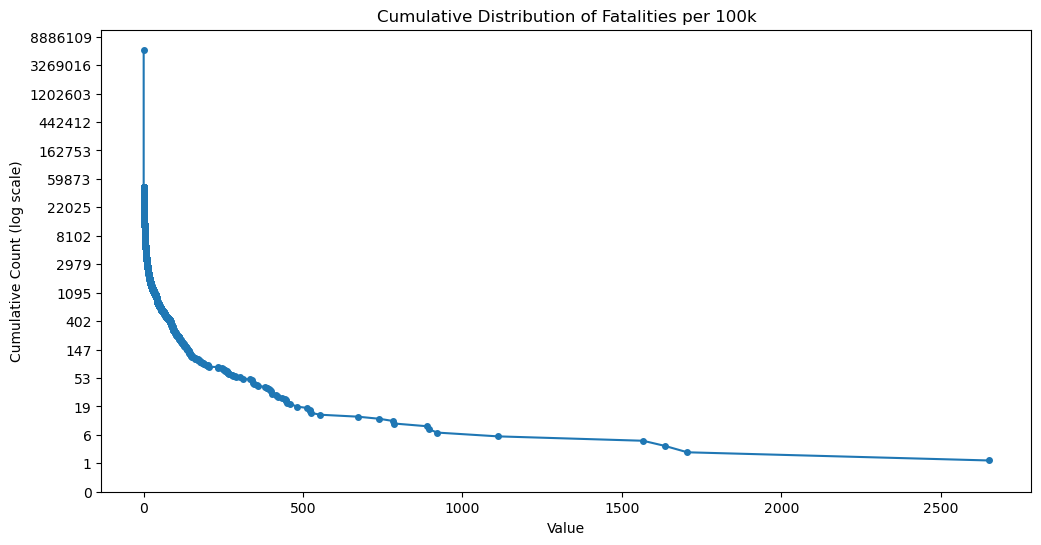

In [12]:
# just to test it
cumulative_distribution = calculate_cumulative_distribution(df_fe, 'fatalities_per_100k')
plot_cumulative_distribution(cumulative_distribution, 'Value', 'Cumulative Count (log scale)', 'Cumulative Distribution of Fatalities per 100k')

In [13]:
def calculate_probabilities(df, value_col, time_col):
    """
    Calculate probabilities p_i and P_i for each unique value in the dataset and map them to the original DataFrame.

    Parameters:
    df (pd.DataFrame): The dataframe containing voxel data.
    value_col (str): The name of the column containing voxel values.
    time_col (str): The name of the column representing time units.
    stat_measure (str): The statistical measure to use for num_units_per_time_unit ('mean', 'median', 'mode').

    Returns:
    pd.DataFrame: The original dataframe with added columns for unit_likelihood and time_unit_likelihood.
    """
    # Check if the DataFrame is empty
    if df.empty:
        raise ValueError("The input DataFrame is empty.")
    
    # Check if the specified columns exist in the DataFrame
    if value_col not in df.columns:
        raise ValueError(f"The specified value column '{value_col}' does not exist in the DataFrame.")
    if time_col not in df.columns:
        raise ValueError(f"The specified time column '{time_col}' does not exist in the DataFrame.")
    
    # Calculate cumulative distribution
    try:
        cumulative_distribution = calculate_cumulative_distribution(df, value_col)
        
    except Exception as e:
        raise RuntimeError(f"Error calculating cumulative distribution: {e}")
    
    # Calculate total number of units
    total_units = df.shape[0]
    
    # Calculate the number of units per time unit
    num_units_per_time_unit = df.groupby(time_col).size().mean() # same as just taking one month

    # Calculate p_i (unit likelihood)
    p_i = cumulative_distribution / total_units
    
    # Calculate P_i (time unit likelihood)
    P_i = 1 - (1 - p_i)**num_units_per_time_unit
    
    # Create a DataFrame with values, p_i, and P_i
    probabilities_df = pd.DataFrame({
        value_col: cumulative_distribution.index,
        f'{value_col}_unit_likelihood': p_i.values,
        f'{value_col}_time_unit_likelihood': P_i.values
    })
    
    # Merge the probabilities_df with the original df on the value_col
    df = df.merge(probabilities_df, left_on=value_col, right_on=value_col, how='left')
    
    return df

In [14]:
df[df['month_id'] == 109]

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
1415880       109   62356      1     1989   192  436   87      0.0      0.0   
1415881       109   79599      1     1989   192  399  111      0.0      0.0   
1415882       109   79600      1     1989   192  400  111      0.0      0.0   
1415883       109   79601      1     1989   192  401  111      0.0      0.0   
1415884       109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
1428985       109  190496      1     1989    89  416  265      0.0      0.0   
1428986       109  190507      1     1989    96  427  265      0.0      0.0   
1428987       109  190508      1     1989    96  428  265      0.0      0.0   
1428988       109  190510      1     1989    96  430  265      0.0      0.0   
1428989       109  190511      1     1989    96  431  265      0.0      0.0   

         os_best    pop_gpw_sum  total_best  fatalities_per_100k  sb_per_100k  \
1415880      0.0       0.000000         0.0                  0.0          0.0   
1415881      0.0    3890.091064         0.0                  0.0          0.0   
1415882      0.0    2452.416016         0.0                  0.0          0.0   
1415883      0.0   11328.425781         0.0                  0.0          0.0   
1415884      0.0  313145.781250         0.0                  0.0          0.0   
...          ...            ...         ...                  ...          ...   
1428985      0.0   37822.867188         0.0                  0.0          0.0   
1428986      0.0    1067.274170         0.0                  0.0          0.0   
1428987      0.0     131.431396         0.0                  0.0          0.0   
1428988      0.0    3071.587891         0.0                  0.0          0.0   
1428989      0.0    3000.236572         0.0                  0.0          0.0   

         ns_per_100k  os_per_100k  
1415880          0.0          0.0  
1415881          0.0          0.0  
1415882          0.0          0.0  
1415883          0.0          0.0  
1415884          0.0          0.0  
...              ...          ...  
1428985          0.0          0.0  
1428986          0.0          0.0  
1428987          0.0          0.0  
1428988          0.0          0.0  
1428989          0.0          0.0  

[13110 rows x 16 columns]

In [15]:
df.groupby('month_id').size().mean()

13110.0

In [16]:
df_fe = calculate_probabilities(df_fe, 'fatalities_per_100k', 'month_id')
df_fe

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
0             109   62356      1     1989   192  436   87      0.0      0.0   
1             109   79599      1     1989   192  399  111      0.0      0.0   
2             109   79600      1     1989   192  400  111      0.0      0.0   
3             109   79601      1     1989   192  401  111      0.0      0.0   
4             109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
5506195       528  190496     12     2023    89  416  265      0.0      0.0   
5506196       528  190507     12     2023    96  427  265      0.0      0.0   
5506197       528  190508     12     2023    96  428  265      0.0      0.0   
5506198       528  190510     12     2023    96  430  265      0.0      0.0   
5506199       528  190511     12     2023    96  431  265      0.0      0.0   

         os_best    pop_gpw_sum  total_best  fatalities_per_100k  sb_per_100k  \
0            0.0       0.000000         0.0                  0.0          0.0   
1            0.0    3890.091064         0.0                  0.0          0.0   
2            0.0    2452.416016         0.0                  0.0          0.0   
3            0.0   11328.425781         0.0                  0.0          0.0   
4            0.0  313145.781250         0.0                  0.0          0.0   
...          ...            ...         ...                  ...          ...   
5506195      0.0   33143.308594         0.0                  0.0          0.0   
5506196      0.0     769.687866         0.0                  0.0          0.0   
5506197      0.0      94.784584         0.0                  0.0          0.0   
5506198      0.0    2036.697510         0.0                  0.0          0.0   
5506199      0.0    1989.386230         0.0                  0.0          0.0   

         ns_per_100k  os_per_100k  fatalities_per_100k_unit_likelihood  \
0                0.0          0.0                                  1.0   
1                0.0          0.0                                  1.0   
2                0.0          0.0                                  1.0   
3                0.0          0.0                                  1.0   
4                0.0          0.0                                  1.0   
...              ...          ...                                  ...   
5506195          0.0          0.0                                  1.0   
5506196          0.0          0.0                                  1.0   
5506197          0.0          0.0                                  1.0   
5506198          0.0          0.0                                  1.0   
5506199          0.0          0.0                                  1.0   

         fatalities_per_100k_time_unit_likelihood  
0                                             1.0  
1                                             1.0  
2                                             1.0  
3                                             1.0  
4                                             1.0  
...                                           ...  
5506195                                       1.0  
5506196                                       1.0  
5506197                                       1.0  
5506198                                       1.0  
5506199                                       1.0  

[5506200 rows x 18 columns]

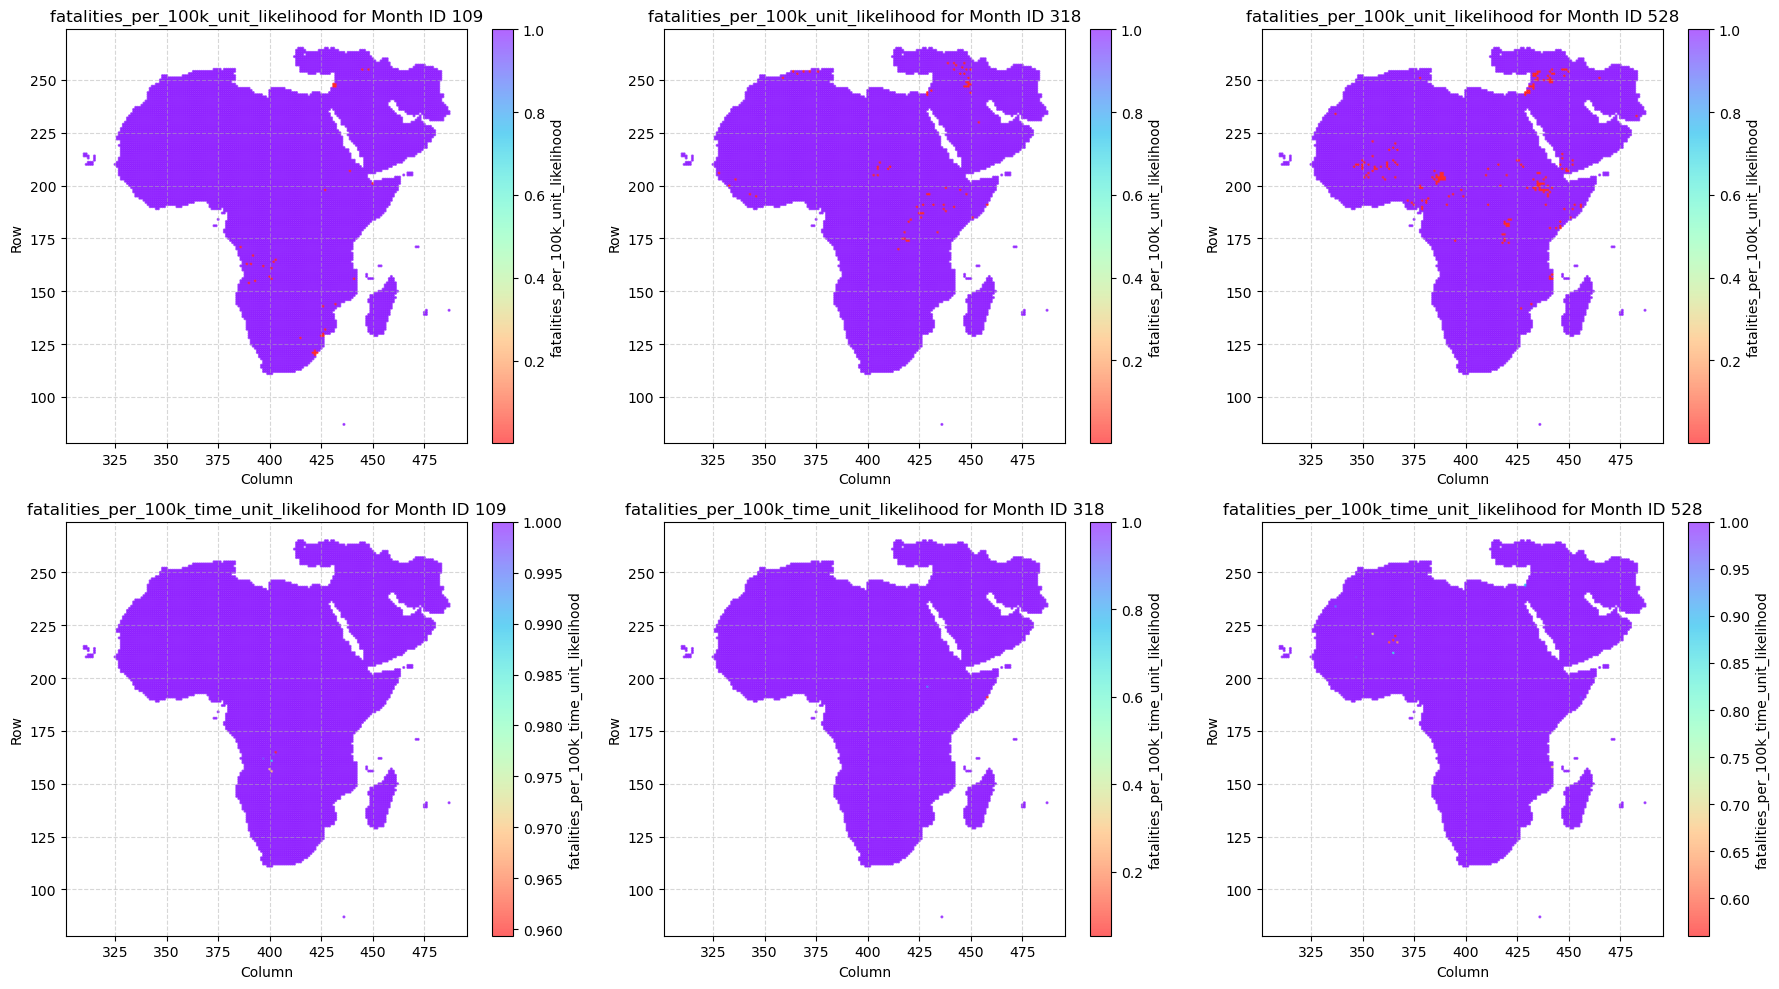

In [17]:
# lets plot the new data
month_ids = [109, 318, 528]
columns = ['fatalities_per_100k_unit_likelihood', 'fatalities_per_100k_time_unit_likelihood']
plot_monthly_data(df_fe, month_ids, columns, figsize=(18, 10), cmap="rainbow_r", alpha=0.6, marker='.', s=6)


In [18]:
def calculate_return_periods(df, p_i_col, P_i_col):
    """
    Calculate the expected number of time periods and voxels to survey to find at least one voxel with a value greater than or equal to i.

    Parameters:
    df (pd.DataFrame): Dataframe containing values, p_i, and P_i.
    p_i_col (str): The name of the column containing unit likelihoods (p_i).
    P_i_col (str): The name of the column containing time unit likelihoods (P_i).

    Returns:
    pd.DataFrame: The original dataframe with added columns for time unit return periods (E_i) and unit return periods (E_{i}^{voxels}).
    """
    # Infer value_col by removing the '_unit_likelihood' suffix from p_i_col
    value_col = p_i_col.replace("_unit_likelihood", "")

    # Calculate E_i = 1 / P_i
    df[f'{value_col}_time_unit_return_period'] = 1 / df[P_i_col]
    
    # Calculate E_{i}^{voxels} = 1 / p_i
    df[f'{value_col}_unit_return_period'] = 1 / df[p_i_col]
    
    return df

In [19]:
df_fe = calculate_return_periods(df_fe, 'fatalities_per_100k_unit_likelihood', 'fatalities_per_100k_time_unit_likelihood')

In [20]:

df_fe

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
0             109   62356      1     1989   192  436   87      0.0      0.0   
1             109   79599      1     1989   192  399  111      0.0      0.0   
2             109   79600      1     1989   192  400  111      0.0      0.0   
3             109   79601      1     1989   192  401  111      0.0      0.0   
4             109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
5506195       528  190496     12     2023    89  416  265      0.0      0.0   
5506196       528  190507     12     2023    96  427  265      0.0      0.0   
5506197       528  190508     12     2023    96  428  265      0.0      0.0   
5506198       528  190510     12     2023    96  430  265      0.0      0.0   
5506199       528  190511     12     2023    96  431  265      0.0      0.0   

         os_best    pop_gpw_sum  total_best  fatalities_per_100k  sb_per_100k  \
0            0.0       0.000000         0.0                  0.0          0.0   
1            0.0    3890.091064         0.0                  0.0          0.0   
2            0.0    2452.416016         0.0                  0.0          0.0   
3            0.0   11328.425781         0.0                  0.0          0.0   
4            0.0  313145.781250         0.0                  0.0          0.0   
...          ...            ...         ...                  ...          ...   
5506195      0.0   33143.308594         0.0                  0.0          0.0   
5506196      0.0     769.687866         0.0                  0.0          0.0   
5506197      0.0      94.784584         0.0                  0.0          0.0   
5506198      0.0    2036.697510         0.0                  0.0          0.0   
5506199      0.0    1989.386230         0.0                  0.0          0.0   

         ns_per_100k  os_per_100k  fatalities_per_100k_unit_likelihood  \
0                0.0          0.0                                  1.0   
1                0.0          0.0                                  1.0   
2                0.0          0.0                                  1.0   
3                0.0          0.0                                  1.0   
4                0.0          0.0                                  1.0   
...              ...          ...                                  ...   
5506195          0.0          0.0                                  1.0   
5506196          0.0          0.0                                  1.0   
5506197          0.0          0.0                                  1.0   
5506198          0.0          0.0                                  1.0   
5506199          0.0          0.0                                  1.0   

         fatalities_per_100k_time_unit_likelihood  \
0                                             1.0   
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
...                                           ...   
5506195                                       1.0   
5506196                                       1.0   
5506197                                       1.0   
5506198                                       1.0   
5506199                                       1.0   

         fatalities_per_100k_time_unit_return_period  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
5506195                                          1.0   
5506196                                          1.0   
5506197                                          1.0   
5

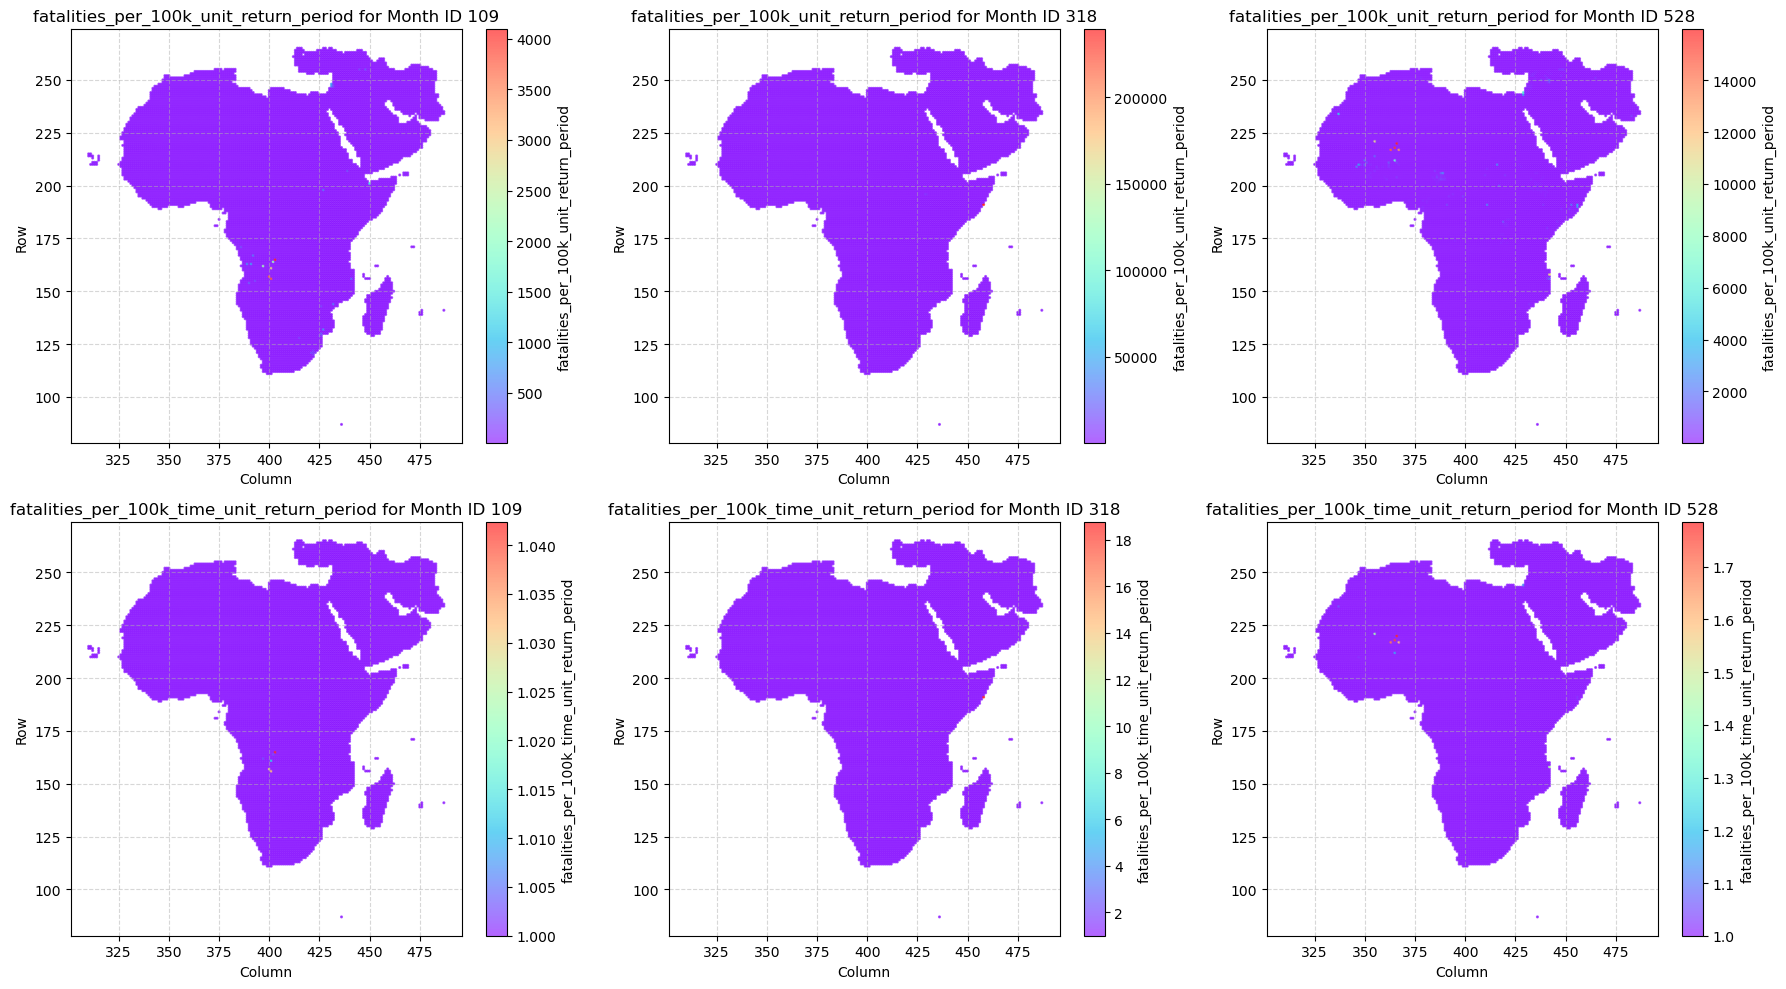

In [21]:
# plot the return periods
month_ids = [109, 318, 528]
columns = ['fatalities_per_100k_unit_return_period', 'fatalities_per_100k_time_unit_return_period']
plot_monthly_data(df_fe, month_ids, columns, figsize=(18, 10), cmap="rainbow", alpha=0.6, marker='.', s=6)


In [22]:
# describe the to return periods
df_fe[['fatalities_per_100k_unit_return_period', 'fatalities_per_100k_time_unit_return_period']].describe()

fatalities_per_100k_unit_return_period  \
count                            5.506200e+06   
mean                             1.176083e+01   
std                              2.218547e+03   
min                              1.000000e+00   
25%                              1.000000e+00   
50%                              1.000000e+00   
75%                              1.000000e+00   
max                              2.753100e+06   

       fatalities_per_100k_time_unit_return_period  
count                                 5.506200e+06  
mean                                  1.000465e+00  
std                                   1.677369e-01  
min                                   1.000000e+00  
25%                                   1.000000e+00  
50%                                   1.000000e+00  
75%                                   1.000000e+00  
max                                   2.105004e+02

# Now put it all toghter

In [23]:
# make a function that combines all the feature engineering functions above

def global_feature_engineering_pipeline(df):

    # Perform feature engineering to calculate fatalities per 100,000 population
    df = feature_eng_fat_per_100k(df)


    # now loop through the columns and calculate probabilities
    columns = ['sb_best', 'ns_best', 'os_best', 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k']
    for col in columns:
        df = calculate_probabilities(df, col, 'month_id')

    # now loop through the columns and calculate return periods
    for col in columns:
        df = calculate_return_periods(df, f'{col}_unit_likelihood', f'{col}_time_unit_likelihood')

    # check that all the new expected columns are created
    new_columns = [ 'total_best', 'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k',
                    'fatalities_per_100k_unit_likelihood', 'fatalities_per_100k_time_unit_likelihood',
                    'sb_per_100k_unit_likelihood', 'sb_per_100k_time_unit_likelihood',
                    'ns_per_100k_unit_likelihood', 'ns_per_100k_time_unit_likelihood',
                    'os_per_100k_unit_likelihood', 'os_per_100k_time_unit_likelihood',
                    'total_best_unit_likelihood', 'total_best_time_unit_likelihood',
                    'fatalities_per_100k_unit_return_period', 'fatalities_per_100k_time_unit_return_period',
                    'sb_per_100k_unit_return_period', 'sb_per_100k_time_unit_return_period',
                    'ns_per_100k_unit_return_period', 'ns_per_100k_time_unit_return_period',
                    'os_per_100k_unit_return_period', 'os_per_100k_time_unit_return_period',
                    'total_best_unit_return_period', 'total_best_time_unit_return_period']
    
    for col in new_columns:
        assert col in df.columns, f"Column {col} is missing from the DataFrame"


    return df

    

In [24]:
df_global_monthly = global_feature_engineering_pipeline(df)

In [25]:
df_global_monthly

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
0             109   62356      1     1989   192  436   87      0.0      0.0   
1             109   79599      1     1989   192  399  111      0.0      0.0   
2             109   79600      1     1989   192  400  111      0.0      0.0   
3             109   79601      1     1989   192  401  111      0.0      0.0   
4             109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
5506195       528  190496     12     2023    89  416  265      0.0      0.0   
5506196       528  190507     12     2023    96  427  265      0.0      0.0   
5506197       528  190508     12     2023    96  428  265      0.0      0.0   
5506198       528  190510     12     2023    96  430  265      0.0      0.0   
5506199       528  190511     12     2023    96  431  265      0.0      0.0   

         os_best  ...  total_best_time_unit_return_period  \
0            0.0  ...                                 1.0   
1            0.0  ...                                 1.0   
2            0.0  ...                                 1.0   
3            0.0  ...                                 1.0   
4            0.0  ...                                 1.0   
...          ...  ...                                 ...   
5506195      0.0  ...                                 1.0   
5506196      0.0  ...                                 1.0   
5506197      0.0  ...                                 1.0   
5506198      0.0  ...                                 1.0   
5506199      0.0  ...                                 1.0   

         total_best_unit_return_period  \
0                                  1.0   
1                                  1.0   
2                                  1.0   
3                                  1.0   
4                                  1.0   
...                                ...   
5506195                            1.0   
5506196                            1.0   
5506197                            1.0   
5506198                            1.0   
5506199                            1.0   

         fatalities_per_100k_time_unit_return_period  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
5506195                                          1.0   
5506196                                          1.0   
5506197                                          1.0   
5506198                                          1.0   
5506199                                          1.0   

         fatalities_per_100k_unit_return_period  \
0                                           1.0   
1                                           1.0   
2                                           1.0   
3                                           1.0   
4                                           1.0   
...                                         ...   
5506195                                     1.0   
5506196                                     1.0   
5506197                                     1.0   
5506198                                     1.0   
5506199                                     1.0   

         sb_per_100k_time_unit_return_period  sb_per_100k_unit_return_period  \
0                                        1.0                             1.0   
1                                        1.0                             1.0   
2                                        1.0                             1.0   
3                                        1.0                             1.0   
4                                        1.0                             1.0   
...                                      ...            

### and now country wise:

In [26]:
def calculate_country_probabilities_per_country(country_df: pd.DataFrame, value_col: str, time_col: str) -> pd.DataFrame:
    """
    Calculate the probabilities p_i and P_i for each unique value in the dataset for a given country.

    Parameters:
    - country_df (pd.DataFrame): DataFrame containing data for a single country.
    - value_col (str): The column name for the voxel values.
    - time_col (str): The column name for the time periods.

    Returns:
    - pd.DataFrame: DataFrame with added columns for p_i and P_i probabilities.
    """
    # Calculate cumulative distribution
    cumulative_distribution = country_df[value_col].rank(method='max') / len(country_df)
    
    # Calculate total number of voxels
    total_units = len(country_df)
    
    # Calculate number of units per time unit
    num_units_per_time_unit = country_df.groupby(time_col).size().mean()
    
    # Calculate p_i
    p_i = cumulative_distribution / total_units
    
    # Calculate P_i
    P_i = 1 - (1 - p_i)**num_units_per_time_unit
    
    # Ensure p_i and P_i for 0 are set to 1
    zero_mask = country_df[value_col] == 0
    p_i[zero_mask] = 1
    P_i[zero_mask] = 1
    
    # Add results to DataFrame
    country_df[f'{value_col}_unit_likelihood_country'] = p_i.values
    country_df[f'{value_col}_time_unit_likelihood_country'] = P_i.values
    
    return country_df

In [27]:
def calculate_all_country_probabilities(df: pd.DataFrame, value_col: str, time_col: str, stat_measure: str) -> pd.DataFrame:
    """
    Calculate the probabilities p_i and P_i for each unique value in the dataset for all countries.

    Parameters:
    - df (pd.DataFrame): DataFrame containing data for all countries.
    - value_col (str): The column name for the voxel values.
    - time_col (str): The column name for the time periods.
    - stat_measure (str): The statistical measure to use ('mean', 'median', 'mode').

    Returns:
    - pd.DataFrame: DataFrame with added columns for p_i and P_i probabilities for all countries.
    """
    if df.empty:
        raise ValueError("The input DataFrame is empty.")
    
    if value_col not in df.columns:
        raise ValueError(f"The specified value column '{value_col}' does not exist in the DataFrame.")
    
    if time_col not in df.columns:
        raise ValueError(f"The specified time column '{time_col}' does not exist in the DataFrame.")
    
    valid_measures = ['mean', 'median', 'mode']
    if stat_measure not in valid_measures:
        raise ValueError(f"Invalid stat_measure. Choose from {valid_measures}.")
    
    countries = df['c_id'].unique()
    
    with Pool() as pool:
        results = pool.starmap(
            calculate_country_probabilities_per_country, 
            [(df[df['c_id'] == country], value_col, time_col) for country in countries]
        )
    
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df

In [28]:
#def calculate_country_probabilities_per_country(country_df, value_col, time_col, stat_measure):
#    """
#    Calculate country-specific probabilities p_i and P_i for a single country.
#
#    Parameters:
#    country_df (pd.DataFrame): The dataframe containing voxel data for a single country.
#    value_col (str): The name of the column containing voxel values.
#    time_col (str): The name of the column representing time units.
#    stat_measure (str): The statistical measure to use for num_units_per_time_unit ('mean', 'median', 'mode').
#
#    Returns:
#    pd.DataFrame: The dataframe with added columns for unit_likelihood_country and time_unit_likelihood_country.
#    """
#    # Calculate cumulative distribution
#    cumulative_distribution = country_df[value_col].rank(method='max') / len(country_df)
#    
#    # Calculate total number of units
#    total_units = country_df.shape[0]
#
#    # Calculate the number of units per time unit
#    num_units_per_time_unit = country_df.groupby(time_col).size().mean() # same as just taking one month
#
#    # Calculate p_i (unit likelihood)
#    p_i = cumulative_distribution / total_units
#    
#    # Calculate P_i (time unit likelihood)
#    P_i = 1 - (1 - p_i)**num_units_per_time_unit
#    
#    # Ensure p_i and P_i for 0 are set to 1
#    p_i[country_df[value_col] == 0] = 1
#    P_i[country_df[value_col] == 0] = 1
#    
#    # Add the results to the DataFrame
#    country_df[f'{value_col}_unit_likelihood_country'] = p_i.values
#    country_df[f'{value_col}_time_unit_likelihood_country'] = P_i.values
#    
#    return country_df
#
#def calculate_all_country_probabilities(df, value_col, time_col, stat_measure='mean'):
#    """
#    Calculate all country-specific probabilities p_i and P_i for each unique value in the dataset and map them to the original DataFrame.
#
#    Parameters:
#    df (pd.DataFrame): The dataframe containing voxel data.
#    value_col (str): The name of the column containing voxel values.
#    time_col (str): The name of the column representing time units.
#    stat_measure (str): The statistical measure to use for num_units_per_time_unit ('mean', 'median', 'mode').
#
#    Returns:
#    pd.DataFrame: The original dataframe with added columns for unit_likelihood_country and time_unit_likelihood_country.
#    """
#    # Check if the DataFrame is empty
#    if df.empty:
#        raise ValueError("The input DataFrame is empty.")
#    
#    # Check if the specified columns exist in the DataFrame
#    if value_col not in df.columns:
#        raise ValueError(f"The specified value column '{value_col}' does not exist in the DataFrame.")
#    
#    if time_col not in df.columns:
#        raise ValueError(f"The specified time column '{time_col}' does not exist in the DataFrame.")
#    
#    # Check if the stat_measure parameter is valid
#    valid_measures = ['mean', 'median', 'mode']
#    if stat_measure not in valid_measures:
#        raise ValueError(f"Invalid stat_measure. Choose from {valid_measures}.")
#    
#    countries = df['c_id'].unique()
#    
#    # Use multiprocessing to process each country in parallel
#    with Pool() as pool:
#        results = pool.starmap(calculate_country_probabilities_per_country, [(df[df['c_id'] == country], value_col, time_col, stat_measure) for country in countries])
#    
#    # Concatenate the results
#    result_df = pd.concat(results, ignore_index=True)
#    
#    return result_df
#
df_global_monthly = calculate_all_country_probabilities(df_global_monthly, 'fatalities_per_100k', 'month_id', 'median')
df_global_monthly = calculate_return_periods(df_global_monthly, 'fatalities_per_100k_unit_likelihood_country', 'fatalities_per_100k_time_unit_likelihood_country')

In [29]:
df_global_monthly 

month_id   pg_id  month  year_id  c_id  col  row  sb_best  ns_best  \
0             109   62356      1     1989   192  436   87      0.0      0.0   
1             109   79599      1     1989   192  399  111      0.0      0.0   
2             109   79600      1     1989   192  400  111      0.0      0.0   
3             109   79601      1     1989   192  401  111      0.0      0.0   
4             109   80317      1     1989   192  397  112      0.0      0.0   
...           ...     ...    ...      ...   ...  ...  ...      ...      ...   
5506195       528  160990     12     2023   245  430  224      0.0      0.0   
5506196       528  160991     12     2023   245  431  224      0.0      0.0   
5506197       528  160992     12     2023   245  432  224      0.0      0.0   
5506198       528  160993     12     2023   245  433  224      0.0      0.0   
5506199       528  160994     12     2023   245  434  224      0.0      0.0   

         os_best  ...  sb_per_100k_time_unit_return_period  \
0            0.0  ...                                  1.0   
1            0.0  ...                                  1.0   
2            0.0  ...                                  1.0   
3            0.0  ...                                  1.0   
4            0.0  ...                                  1.0   
...          ...  ...                                  ...   
5506195      0.0  ...                                  1.0   
5506196      0.0  ...                                  1.0   
5506197      0.0  ...                                  1.0   
5506198      0.0  ...                                  1.0   
5506199      0.0  ...                                  1.0   

         sb_per_100k_unit_return_period  ns_per_100k_time_unit_return_period  \
0                                   1.0                                  1.0   
1                                   1.0                                  1.0   
2                                   1.0                                  1.0   
3                                   1.0                                  1.0   
4                                   1.0                                  1.0   
...                                 ...                                  ...   
5506195                             1.0                                  1.0   
5506196                             1.0                                  1.0   
5506197                             1.0                                  1.0   
5506198                             1.0                                  1.0   
5506199                             1.0                                  1.0   

         ns_per_100k_unit_return_period  os_per_100k_time_unit_return_period  \
0                                   1.0                                  1.0   
1                                   1.0                                  1.0   
2                                   1.0                                  1.0   
3                                   1.0                                  1.0   
4                                   1.0                                  1.0   
...                                 ...                                  ...   
5506195                             1.0                                  1.0   
5506196                             1.0                                  1.0   
5506197                             1.0                                  1.0   
5506198                             1.0                                  1.0   
5506199                             1.0                                  1.0   

         os_per_100k_unit_return_period  \
0                                   1.0   
1                                   1.0   
2                                   1.0   
3                                   1.0   
4                                   1.0   
...                                 ...   
5506195                             1.0   
5506196                             1.0   
550619

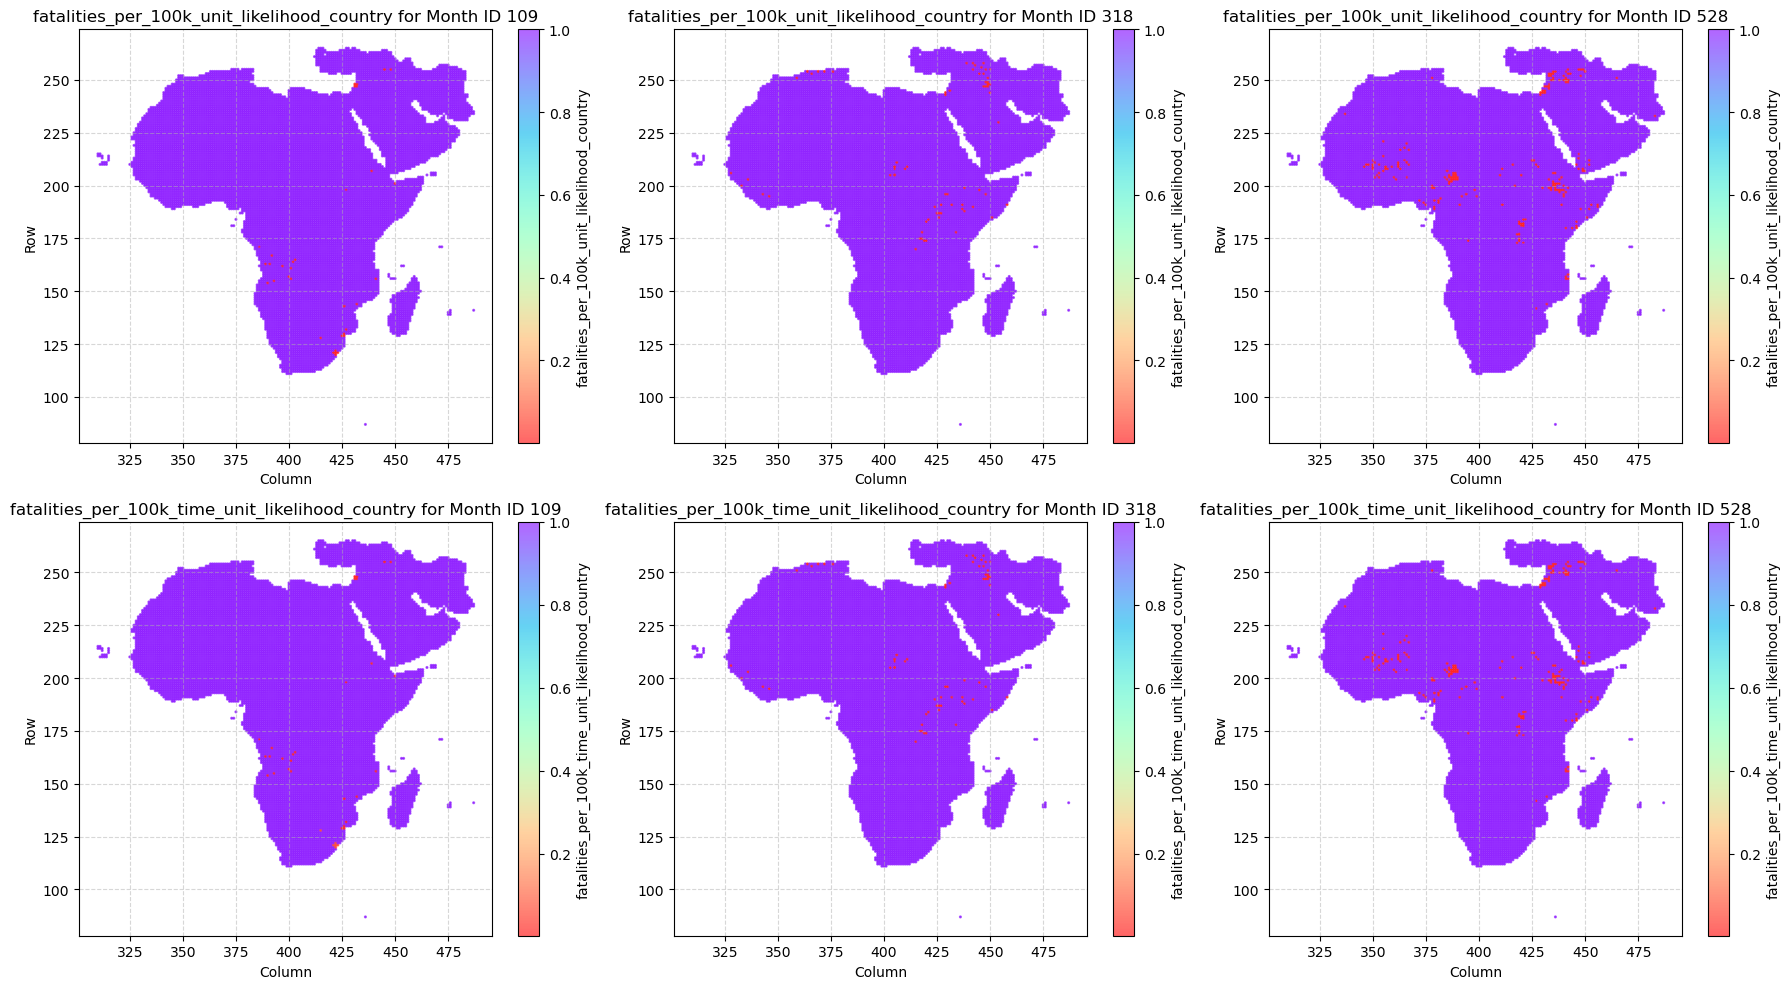

In [30]:
# plot the new country wise features
month_ids = [109, 318, 528]
new_columns =  ['fatalities_per_100k_unit_likelihood_country', 'fatalities_per_100k_time_unit_likelihood_country']
plot_monthly_data(df_global_monthly, month_ids, new_columns, figsize=(18, 10), cmap="rainbow_r", alpha=0.6, marker='.', s=6)

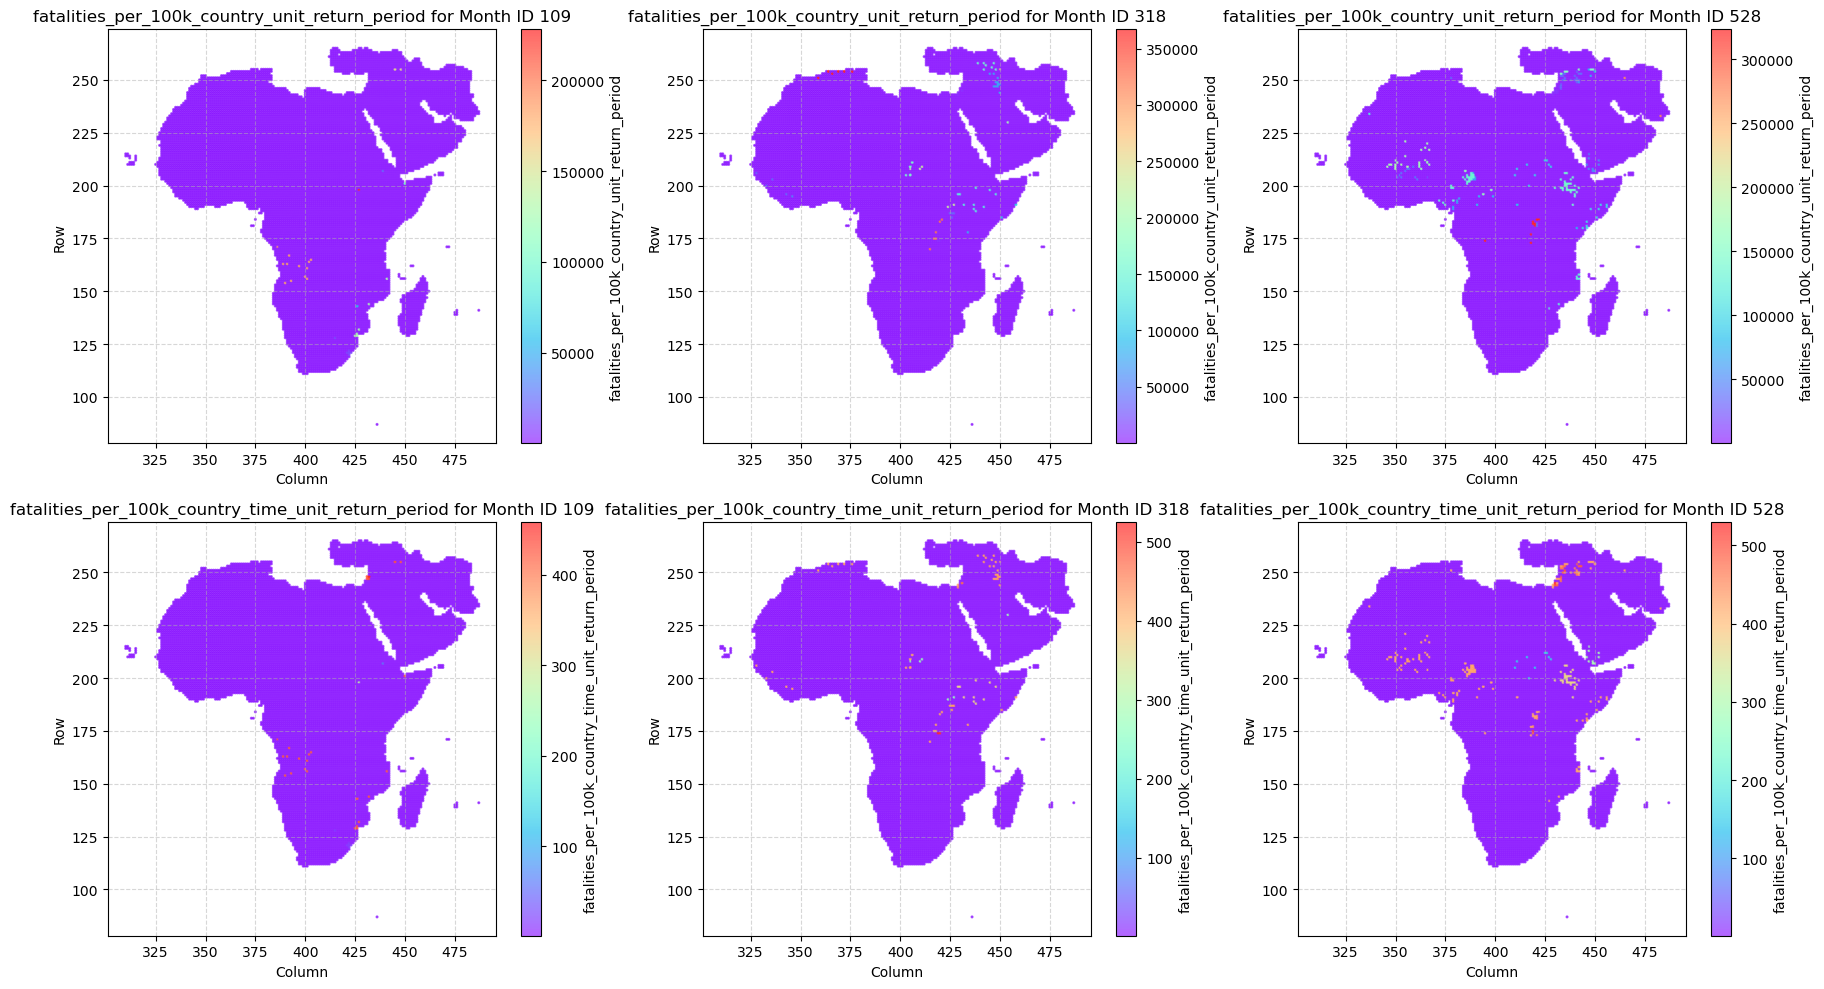

In [31]:
# and plot the new return periods
month_ids = [109, 318, 528]
columns = ['fatalities_per_100k_country_unit_return_period', 'fatalities_per_100k_country_time_unit_return_period']
plot_monthly_data(df_global_monthly, month_ids, columns, figsize=(18, 10), cmap="rainbow", alpha=0.6, marker='.', s=6)

In [32]:
# describe the new data
df_global_monthly[['fatalities_per_100k_country_unit_return_period', 'fatalities_per_100k_country_time_unit_return_period', 'month_id']].describe()

fatalities_per_100k_country_unit_return_period  \
count                                    5.506200e+06   
mean                                     1.018620e+03   
std                                      1.425883e+04   
min                                      1.000000e+00   
25%                                      1.000000e+00   
50%                                      1.000000e+00   
75%                                      1.000000e+00   
max                                      3.672251e+05   

       fatalities_per_100k_country_time_unit_return_period      month_id  
count                                       5.506200e+06    5.506200e+06  
mean                                        4.316926e+00    3.185000e+02  
std                                         3.702491e+01    1.212432e+02  
min                                         1.000000e+00    1.090000e+02  
25%                                         1.000000e+00    2.137500e+02  
50%                                         1.000000e+00    3.185000e+02  
75%                                         1.000000e+00    4.232500e+02  
max                                         5.378128e+02    5.280000e+02